# DATA 602 Project: Sentiment Analysis on Amazon Reviews
* The fierce competition for attracting and retaining customers online is forcing firms to employ creative techniques to improve customer experiences. Companies are increasingly required to evaluate customer evaluations on internet platforms such as Amazon in order to better understand their customers. Companies may use Amazon reviews to do sentiment analysis to learn more about their customers.

* The project aims in predicting the sentiment based on Amazon reviews about cellphones and their accessories.

* Perform the necessary transformations to train a regression and classification models the overall field in the data set. This should include creating the correctly sized training and test sets.

* When performing the classification task, use overall less than 3 as bad, greater than 3 as good, and 3 as neutral.

In [1]:
#!pip install wordcloud

In [2]:
#!pip install keras
!pip install tensorflow

     |████████████████████████████████| 462 kB 15.8 MB/s 


In [3]:
# Libraries to work with arrays and dataframes
import pandas as pd 
import numpy as np

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Libraries for Natural Language Processing
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from tqdm import tqdm


# Machine Learning Libs
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor

# Deep Learning Libraries
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder


In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
!curl http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Cell_Phones_and_Accessories_5.json.gz -o reviews.json.gz
!gunzip reviews.json.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  161M  100  161M    0     0  33.1M      0  0:00:04  0:00:04 --:--:-- 35.6M


In [6]:
!ls

reviews.json  sample_data


In [7]:
reviews = pd.read_json('/content/reviews.json', lines= True,)
reviews.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"08 4, 2014",A24E3SXTC62LJI,7508492919,{'Color:': ' Bling'},Claudia Valdivia,Looks even better in person. Be careful to not...,Can't stop won't stop looking at it,1407110400,NaN,NaN
1,5,True,"02 12, 2014",A269FLZCB4GIPV,7508492919,NaN,sarah ponce,When you don't want to spend a whole lot of ca...,1,1392163200,NaN,NaN
2,3,True,"02 8, 2014",AB6CHQWHZW4TV,7508492919,NaN,Kai,"so the case came on time, i love the design. I...",Its okay,1391817600,NaN,NaN
3,2,True,"02 4, 2014",A1M117A53LEI8,7508492919,NaN,Sharon Williams,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,CASE,1391472000,NaN,NaN
4,4,True,"02 3, 2014",A272DUT8M88ZS8,7508492919,NaN,Bella Rodriguez,"I liked it because it was cute, but the studs ...",Cute!,1391385600,NaN,NaN


In [8]:
# Creating a copy of the dataframe.
reviews_copy = reviews.copy()

## Preprocessing the data

In [9]:
# Checking for the rows and column.
reviews.shape

(1128437, 12)

In [10]:
# Converting the reviewTime to DateTime object
reviews['reviewTime'] = pd.to_datetime(reviews['reviewTime'])
type(reviews['reviewTime'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [11]:

# Function to give review sentiment.
def sentiment(x):
  if(x>3):
    return 2
  if(x<3):
    return 0
  return 1

**Creating a sentiment column**

*   0 - Negative
*   1 - Neutral
* 2 - Positive



In [12]:
# Creating a sentiment column
sent = reviews['overall']
reviews['Sentiment'] = sent.map(sentiment)
reviews['Sentiment'].unique()

array([2, 1, 0])

In [13]:
# Look at the data
reviews.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,Sentiment
0,5,True,2014-08-04,A24E3SXTC62LJI,7508492919,{'Color:': ' Bling'},Claudia Valdivia,Looks even better in person. Be careful to not...,Can't stop won't stop looking at it,1407110400,NaN,NaN,2
1,5,True,2014-02-12,A269FLZCB4GIPV,7508492919,NaN,sarah ponce,When you don't want to spend a whole lot of ca...,1,1392163200,NaN,NaN,2
2,3,True,2014-02-08,AB6CHQWHZW4TV,7508492919,NaN,Kai,"so the case came on time, i love the design. I...",Its okay,1391817600,NaN,NaN,1
3,2,True,2014-02-04,A1M117A53LEI8,7508492919,NaN,Sharon Williams,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,CASE,1391472000,NaN,NaN,0
4,4,True,2014-02-03,A272DUT8M88ZS8,7508492919,NaN,Bella Rodriguez,"I liked it because it was cute, but the studs ...",Cute!,1391385600,NaN,NaN,2


In [14]:
reviews.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image', 'Sentiment'],
      dtype='object')

In [15]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128437 entries, 0 to 1128436
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   overall         1128437 non-null  int64         
 1   verified        1128437 non-null  bool          
 2   reviewTime      1128437 non-null  datetime64[ns]
 3   reviewerID      1128437 non-null  object        
 4   asin            1128437 non-null  object        
 5   style           605241 non-null   object        
 6   reviewerName    1128302 non-null  object        
 7   reviewText      1127672 non-null  object        
 8   summary         1127920 non-null  object        
 9   unixReviewTime  1128437 non-null  int64         
 10  vote            92034 non-null    object        
 11  image           27107 non-null    object        
 12  Sentiment       1128437 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(3), object(8)
memory usage: 104.4+ 

In [16]:
# Dropping the duplicate data
reviews = reviews.drop_duplicates(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote'])
reviews.shape

(1124555, 13)

* Rows initially: **1128437**
* Rows after dropping duplicates: **1124555**

**Handling Null Values**

In [17]:
# Checking for null values
reviews.isnull().sum()

overall                 0
verified                0
reviewTime              0
reviewerID              0
asin                    0
style              520603
reviewerName          135
reviewText            762
summary               515
unixReviewTime          0
vote              1033031
image             1097473
Sentiment               0
dtype: int64

* Highest number of missing values are in vote, image and style.
* I think that those three columns does not impact much on our reviews. So, I decided to drop them.
* Even the review name also doesn't impact much on the sentiment so I decidec to drop it.



In [18]:
# dropping the columns 
reviews = reviews.drop(['vote', 'image', 'style', 'reviewerName'], axis=1)

In [19]:
# Resetting the index after dropping the values.
reviews = reviews.reset_index(drop=True)
reviews.tail()

,overall,verified,reviewTime,reviewerID,asin,reviewText,summary,unixReviewTime,Sentiment
1124550,4,True,2016-12-22,A1QWMCG1FNEP3A,B01HJC7N4C,Good for viewing. But doesn't have a button or...,Good,1482364800,2
1124551,5,False,2016-07-15,A3FOBEJ9UVUTR3,B01HJC7N4C,I was given the Rockrok 3D VR Glasses Headset ...,THE FUTURE IS NOW!!!!!!!,1468540800,2
1124552,5,False,2016-07-14,AMUEAMKB4E33M,B01HJC7N4C,Super Fun! The RockRoc 3d vr headset is waaaay...,Get more out of your smartphone .......,1468454400,2
1124553,5,False,2016-07-13,A2EV91MMOJ3IL4,B01HJC7N4C,Love it!\n\nI've had other VR glasses which al...,Join the VR fun train!,1468368000,2
1124554,5,True,2017-05-11,ARKQD9Z1VPOV2,B01HJH9IN6,i love it,Five Stars,1494460800,2


In [20]:
# Checking the shape
reviews.shape

(1124555, 9)

* I'm leaving the **reviewText** and **summary** columns as it is because for the rows in which the review text and summary is missing the rating(overall) parameter will decide the sentiment.

### Text Preprocessiong

In [21]:
# Concatenating the summary and reviewText
text_data = reviews['summary'] + reviews['reviewText']
text_data.head()

0    Can't stop won't stop looking at itLooks even ...
1    1When you don't want to spend a whole lot of c...
2    Its okayso the case came on time, i love the d...
3    CASEDON'T CARE FOR IT.  GAVE IT AS A GIFT AND ...
4    Cute!I liked it because it was cute, but the s...
dtype: object

In [22]:
# Concatenating text with rating
text_data = pd.DataFrame({"text" : text_data, "rating" : reviews.overall, "Sentiment" : reviews.Sentiment})
text_data.head()

,text,rating,Sentiment
0,Can't stop won't stop looking at itLooks even ...,5,2
1,1When you don't want to spend a whole lot of c...,5,2
2,"Its okayso the case came on time, i love the d...",3,1
3,CASEDON'T CARE FOR IT. GAVE IT AS A GIFT AND ...,2,0
4,"Cute!I liked it because it was cute, but the s...",4,2


In [23]:
# Calculating the length of the text
text_data['len_of_text'] = text_data['text'].str.split().str.len()
text_data.head()

,text,rating,Sentiment,len_of_text
0,Can't stop won't stop looking at itLooks even ...,5,2,55.0
1,1When you don't want to spend a whole lot of c...,5,2,22.0
2,"Its okayso the case came on time, i love the d...",3,1,52.0
3,CASEDON'T CARE FOR IT. GAVE IT AS A GIFT AND ...,2,0,20.0
4,"Cute!I liked it because it was cute, but the s...",4,2,31.0


### EDA

**Distribution of Rating**

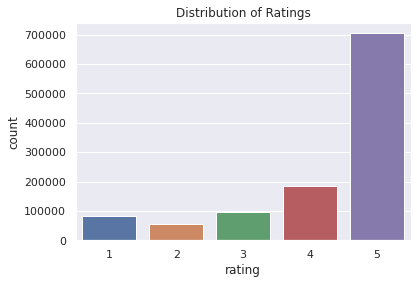

In [24]:
# Plotting the distribution of ratings.
sns.set(style='darkgrid')
sns.countplot(x = 'rating', data= text_data)
plt.title("Distribution of Ratings")
plt.show()

**Observation:** The distribution of ratings is not uniform. There are large number of reviews with rating 5 followed by rating 4.

**Word Count per rating**

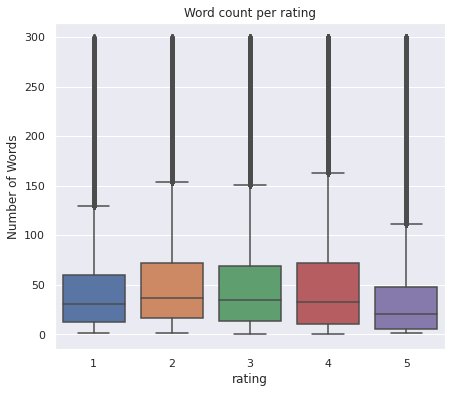

In [25]:
# Plotting word count per rating
plt.figure(figsize=(7, 6))
sns.boxplot(x = 'rating', y = 'len_of_text', data = text_data[text_data['len_of_text'] < 300])# Considering the max words to 300.
plt.title("Word count per rating")
plt.ylabel("Number of Words")
plt.show()

**Observation:** Reviews with rating 5 tend to to be smaller than other reviews.

## Word Cloud
**Function to plot a Word Cloud**

In [26]:
# Reference: https://www.geeksforgeeks.org/generating-word-cloud-python/
def wordcloud(text):

  comment_words = ''
  stopwords = set(STOPWORDS)

# iterate through the csv file 
  for val in text: 
      
    # typecaste each val to string 
      val = str(val) 
  
    # split the value 
      tokens = val.split() 
      
    # Converts each token into lowercase 
      for i in range(len(tokens)): 
          tokens[i] = tokens[i].lower() 
      
      comment_words += " ".join(tokens)+" "
  
  wordcloud = WordCloud(width = 800, height = 800, 
                  background_color ='white', 
                  stopwords = stopwords, 
                  min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wordcloud)
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  plt.show()


**1. Word Cloud for Negative Reviews**

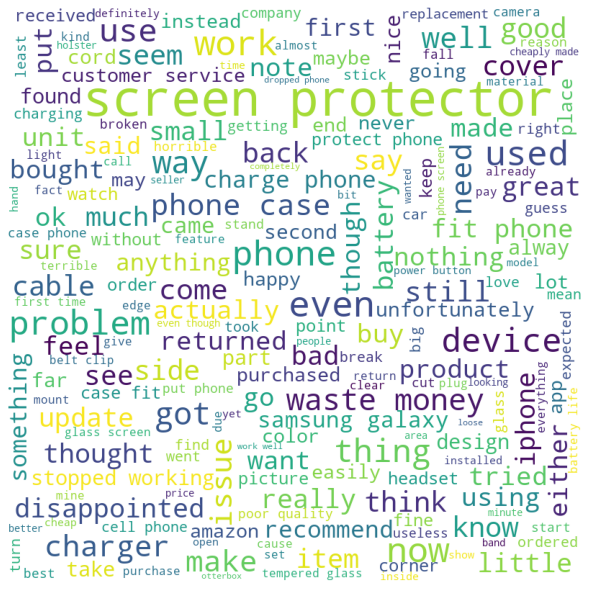

In [27]:
wordcloud(text_data[text_data['Sentiment']==0]['text'])

**Observation:** We can find few -ve words like **disappinted**, **problem**, **issue**, etc.

**2.Word Cloud for Positive reviews**

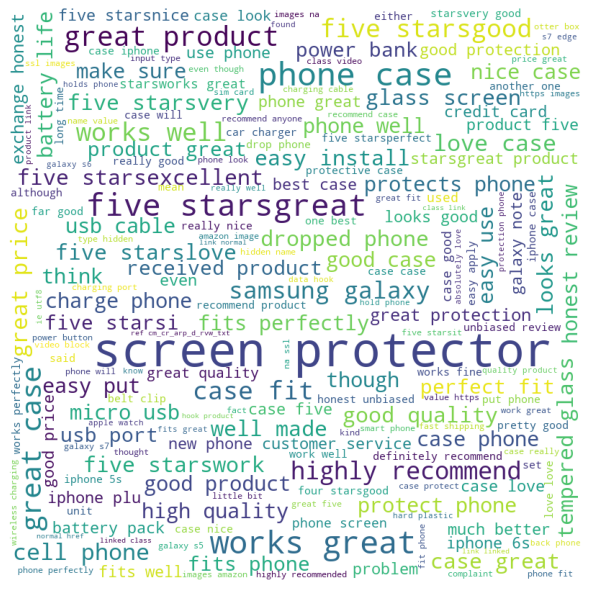

In [28]:
wordcloud(text_data[text_data['Sentiment']==2]['text'])

**Observation:** We can find few +ve words like **great**, **perfect**, **works well**, **good quality**

**3.Word Cloud for Neutral Reviews**

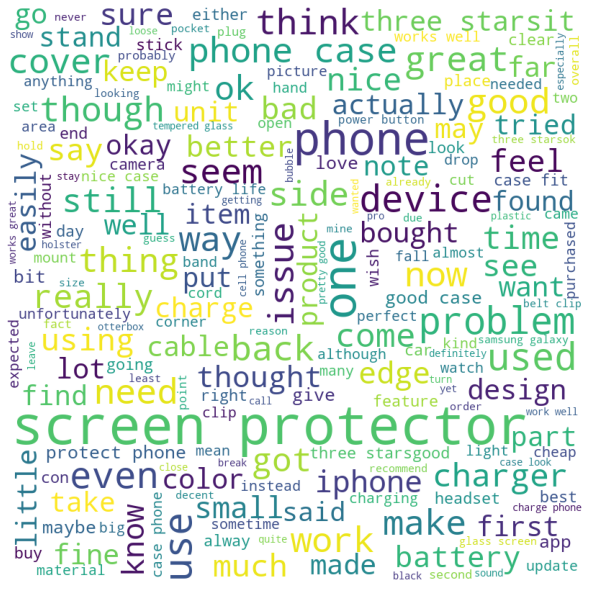

In [29]:
# WordCloud for neutral reviews
wordcloud(text_data[text_data['Sentiment']==1]['text'])

**Obsevation:** We find both positive words like **good**, **nice**, **better**, etc. and negative words like **bad**, **problem**.